In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('.', one_hot=True)
train_X   = mnist.train.images
train_Y = mnist.train.labels
test_X    = mnist.test.images
test_Y  = mnist.test.labels

Extracting .\train-images-idx3-ubyte.gz
Extracting .\train-labels-idx1-ubyte.gz
Extracting .\t10k-images-idx3-ubyte.gz
Extracting .\t10k-labels-idx1-ubyte.gz


In [3]:
device_type = "/gpu:1"

In [4]:
with tf.device(device_type): # <= This is optional
    n_input  = 784
    n_output = 10
    weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
    }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    def conv_model(_input, _w, _b):
        # Reshape input
        _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # Convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # Add-bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # Pass ReLu
        _conv3 = tf.nn.relu(_conv2)
        # Max-pooling
        _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # Vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        # Return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
            , 'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out

In [5]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1
# Functions! 
with tf.device(device_type): # <= This is optional
    prediction = conv_model(x, weights, biases)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    corr = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(corr, tf.float32)) # Accuracy
    init = tf.initialize_all_variables()
# Saver 
save_step = 1;
savedir = "tmp/"
saver = tf.train.Saver(max_to_keep=3) 

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [6]:
do_train = 0
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [7]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: test_X, y: test_Y})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        #if epoch % save_step == 0:
        #    saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

In [12]:
saver.save(sess, savedir + 'save_net.ckpt')

'tmp/save_net.ckpt'

In [8]:
if do_train == 0:
    saver.restore(sess, 'tmp/save_net.ckpt')
    print ("NETWORK RESTORED")

NETWORK RESTORED


In [9]:
with tf.device(device_type):
    conv_out = conv_model(x, weights, biases)

input_r = sess.run(conv_out['input_r'], feed_dict={x: train_X[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: train_X[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: train_X[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: train_X[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: train_X[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: train_X[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: train_X[0:1, :]})

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


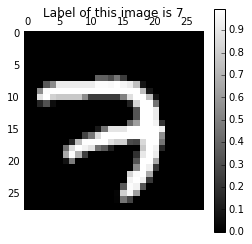

In [10]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(train_Y[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

Size of 'conv1' is (1, 28, 28, 64)


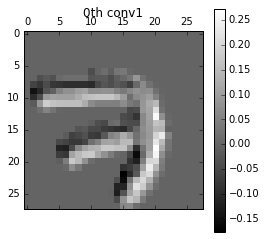

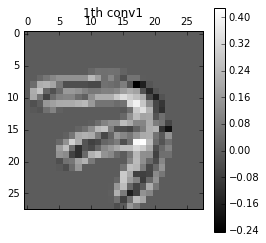

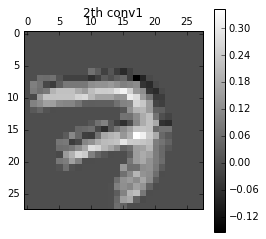

In [11]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show() 

Size of 'conv1' is (3, 3, 1, 64)


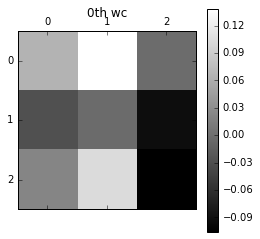

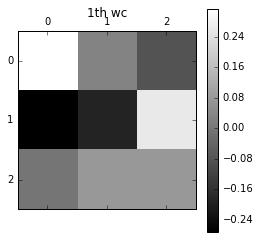

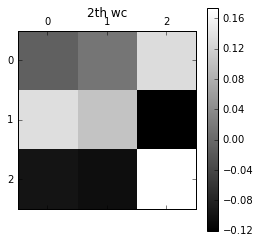

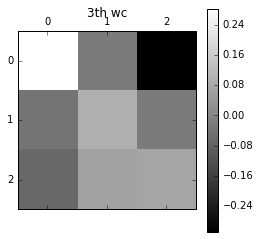

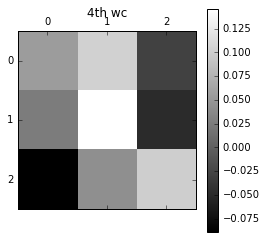

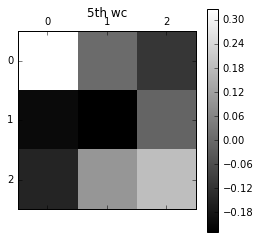

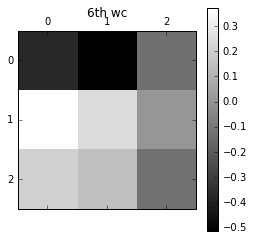

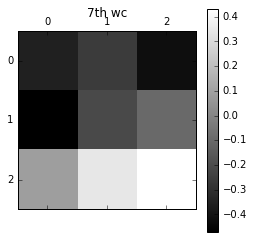

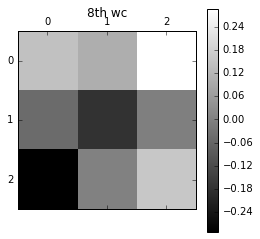

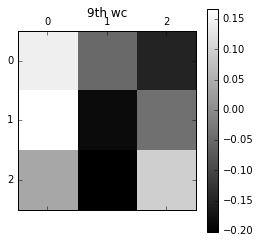

In [12]:
# Let's see 'wc'
wc = sess.run(weights['wc1'])
print ("Size of 'conv1' is %s" % (wc.shape,))

# Plot ! 
for i in range(10):
    plt.matshow(wc[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th wc")
    plt.colorbar()
    plt.show() 

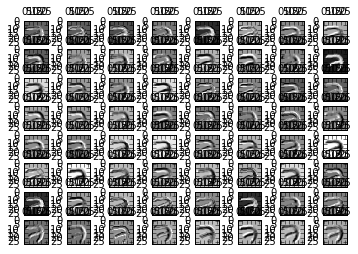

In [13]:
for i in range(64):
    p = plt.subplot(8, 8, i + 1)
    p.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
plt.show() 

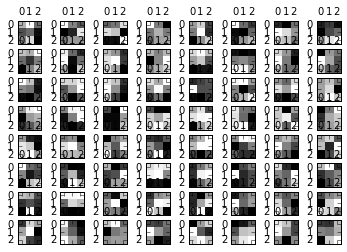

In [14]:
for i in range(64):
    p = plt.subplot(8, 8, i + 1)
    p.matshow(wc[:, :, 0, i], cmap=plt.get_cmap('gray'))
plt.show() 

In [15]:
wc[:, :, 0, 0]

array([[ 0.06669507,  0.13871954, -0.00245746],
       [-0.02883579, -0.00322537, -0.09278449],
       [ 0.02153191,  0.10362031, -0.10581557]], dtype=float32)

12544

In [159]:
#############################################################################################################################################
_w = sess.run(weights['wd1'])
_w.shape

(12544, 10)

In [160]:
w_seven = _w[:, 7]

In [161]:
type(w_seven)

numpy.ndarray

In [162]:
w_seven.shape

(12544,)

In [163]:
w_seven

array([-0.06604233,  0.05880814,  0.11739757, ...,  0.02912133,
       -0.04674924,  0.0119945 ], dtype=float32)

In [164]:
np.sum(w_seven**2)

236.70139

In [165]:
sum_square = np.sum(w_seven**2)
w_1 = w_seven / sum_square

In [166]:
np.shape(w_1)

(12544,)

In [167]:
w_1 = np.reshape(w_1, (1, 12544))

In [168]:
w_1.shape

(1, 12544)

In [171]:
i1 = w_1[0, 0:196]
np.shape(i1)

(196,)

In [172]:
i1 = np.reshape(i1, (14, 14))

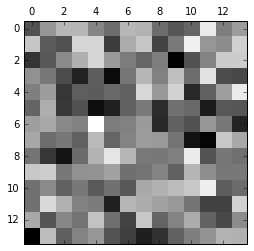

In [173]:
#plt.matshow(w_1[:, :, 0], cmap=plt.get_cmap('gray'))
#plt.show()
plt.matshow(i1, cmap=plt.get_cmap('gray'))
plt.show()

Size of 'pool' is (1, 14, 14, 64)


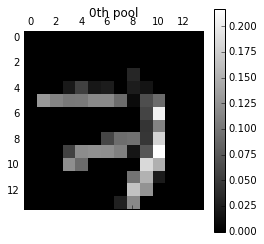

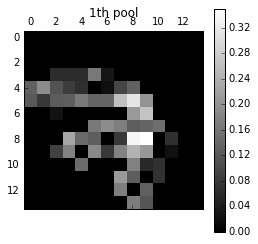

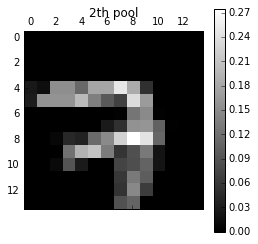

In [79]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

In [77]:
weights['wd1'].get_shape().as_list()[0]

12544

In [104]:
pool[0, :, :, 0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.03240995,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.02184681,  0.05473046,
         0.01993204,  0.02414576,  0.        ,  0.02454879,  0.01743715,
         0.        ,  0.  

In [105]:
dense[0, 14:28]

array([ 0.        ,  0.        ,  0.08506954,  0.        ,  0.        ,
        0.11236978,  0.        ,  0.00154594,  0.        ,  0.        ,
        0.0007228 ,  0.00317314,  0.        ,  0.        ], dtype=float32)

In [108]:
_dense = sess.run(tf.reshape(_pool, [1, 12544]))

In [109]:
_dense[0, 14:28]

array([ 0.        ,  0.        ,  0.08506954,  0.        ,  0.        ,
        0.11236978,  0.        ,  0.00154594,  0.        ,  0.        ,
        0.0007228 ,  0.00317314,  0.        ,  0.        ], dtype=float32)

In [107]:
_pool = sess.run(tf.reshape(dense, [1, 14, 14, 64]))

In [174]:

_pool = sess.run(tf.reshape(w_1, [1, 14, 14, 64]))

Size of 'pool' is (1, 14, 14, 64)


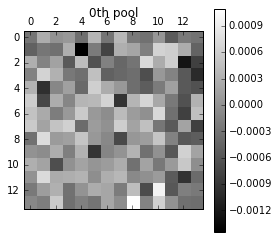

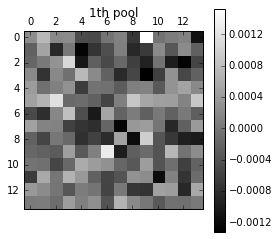

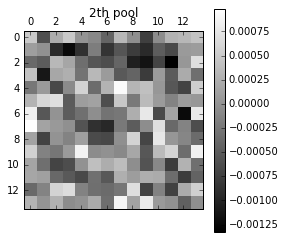

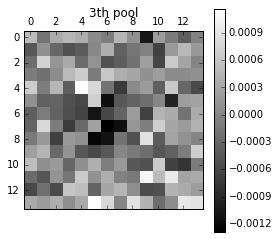

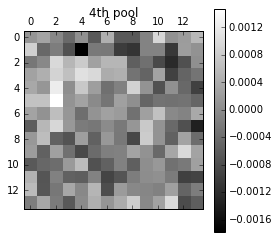

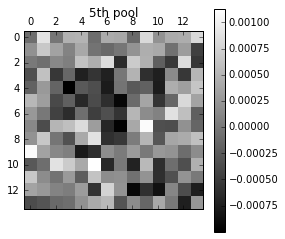

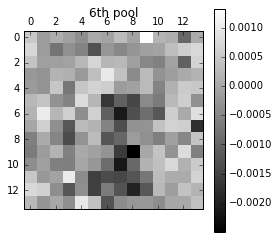

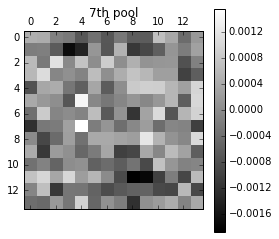

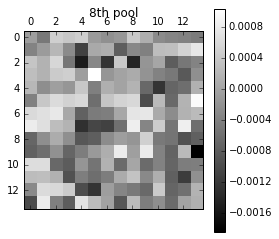

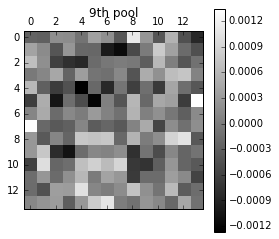

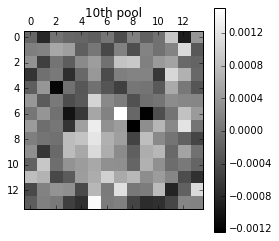

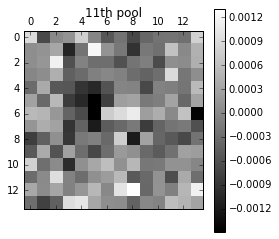

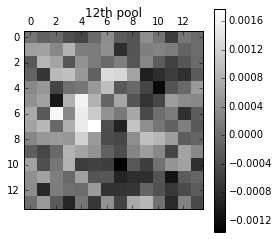

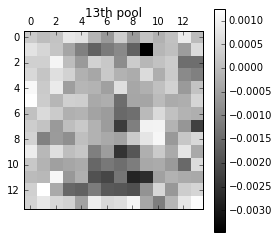

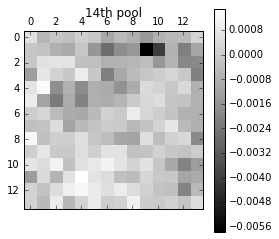

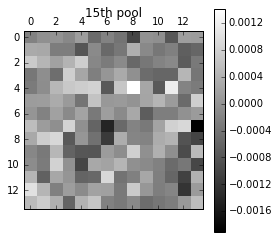

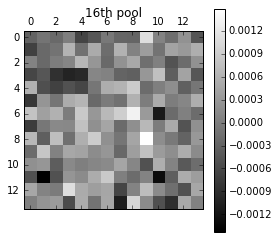

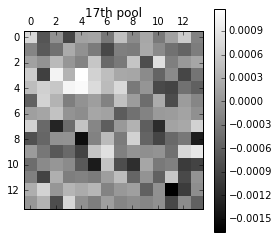

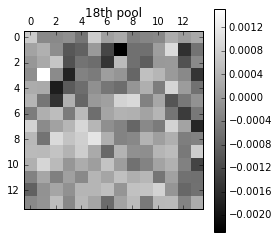

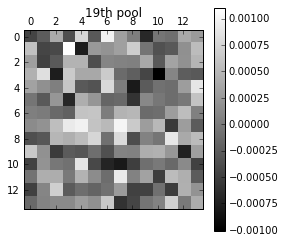

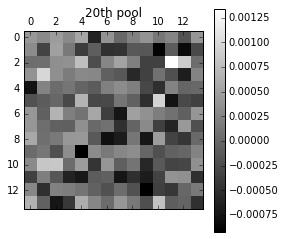

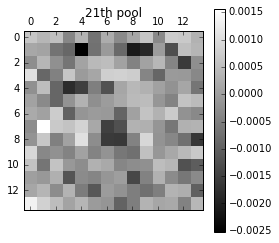

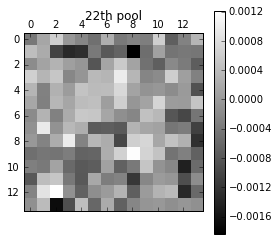

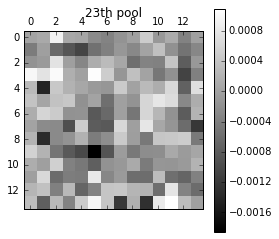

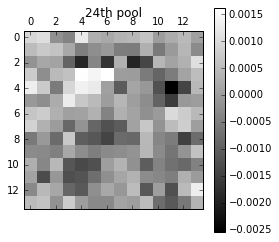

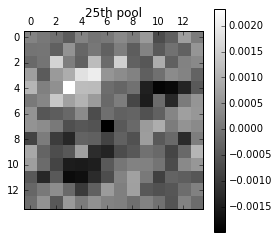

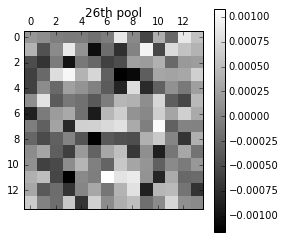

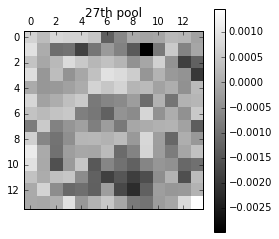

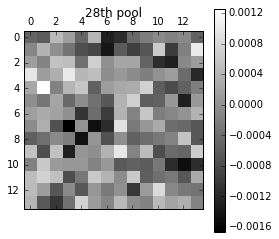

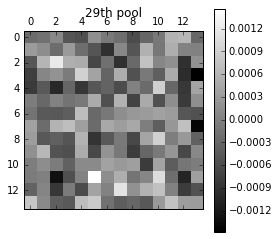

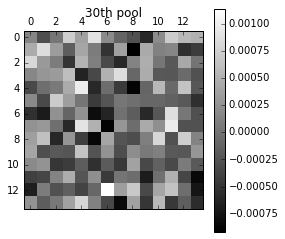

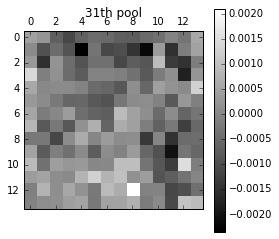

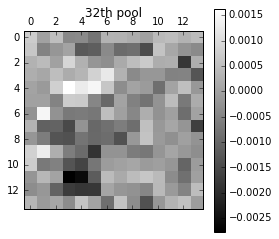

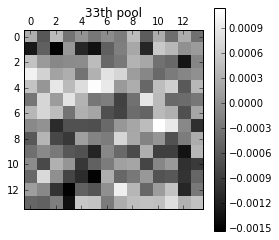

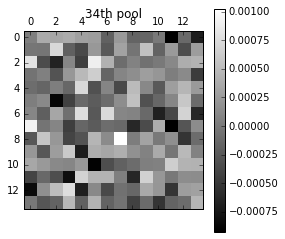

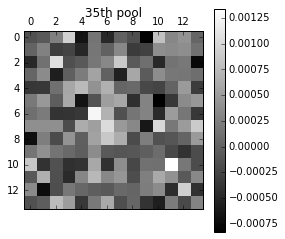

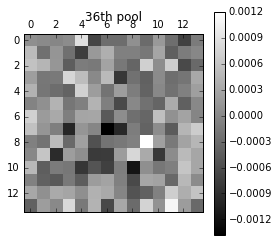

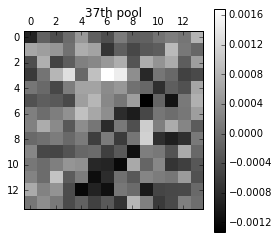

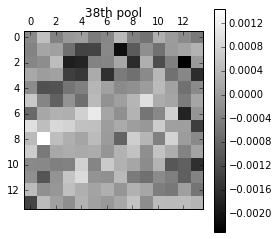

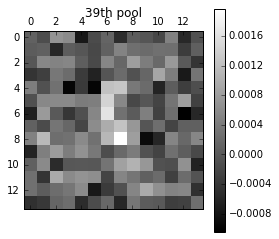

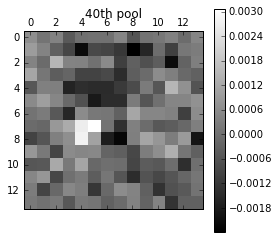

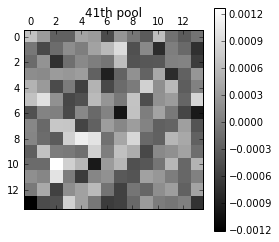

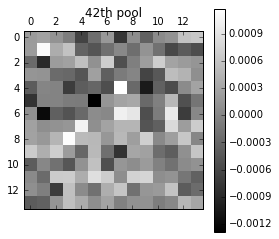

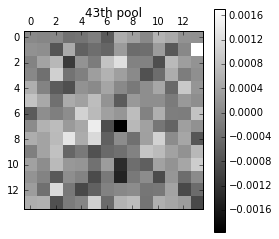

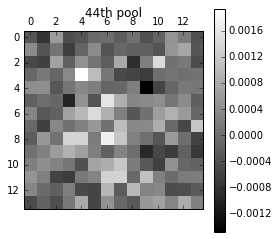

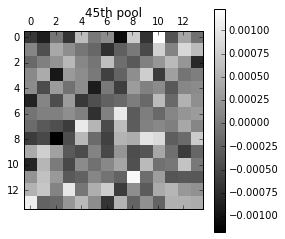

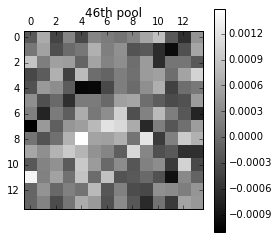

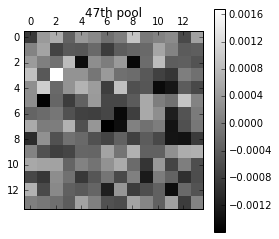

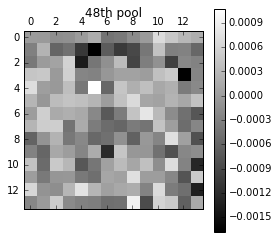

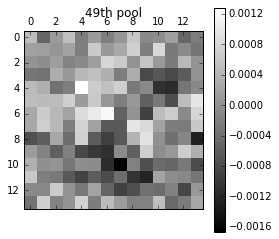

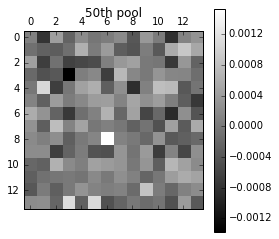

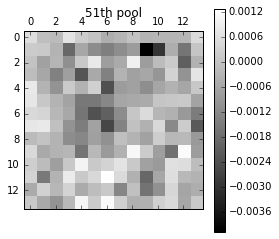

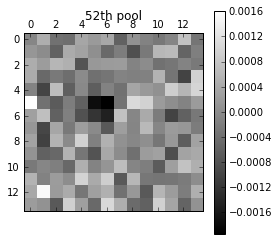

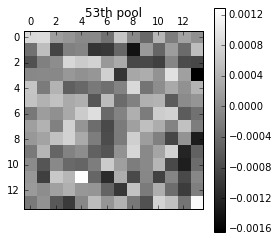

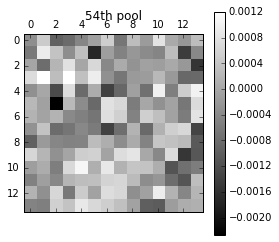

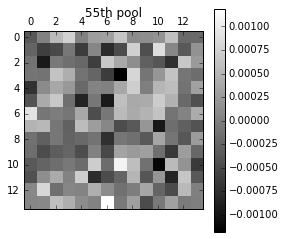

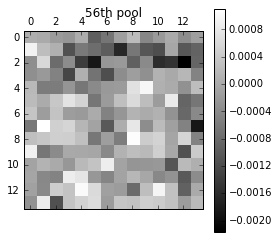

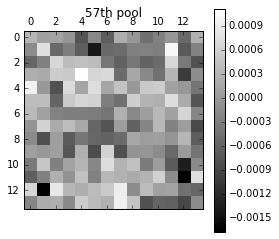

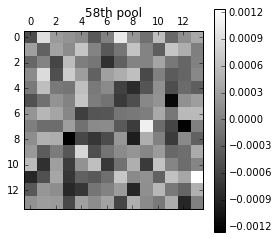

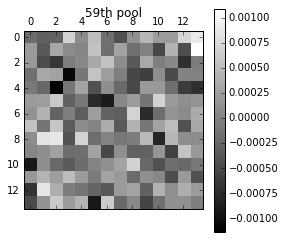

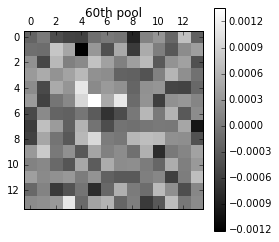

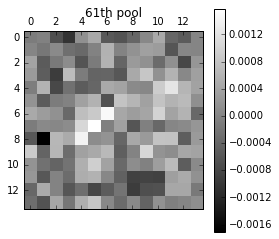

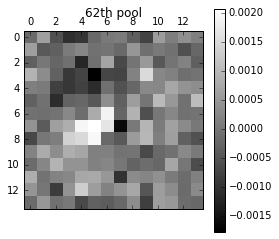

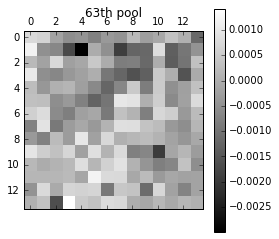

In [175]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (_pool.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(_pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

In [179]:
_pool[0, :, :, 0]

array([[ -2.79011176e-04,   2.64810980e-04,   6.80171115e-06,
          6.53454481e-05,  -3.32268915e-04,   3.58074903e-04,
         -2.75602477e-04,   3.82612867e-04,  -2.23400231e-04,
         -3.17201804e-04,   5.45010771e-05,  -5.37339074e-04,
         -2.28555116e-04,  -2.99023639e-04],
       [ -4.62813274e-04,  -2.65117531e-04,  -3.28448252e-04,
          2.82986264e-04,  -1.44306372e-03,  -2.14632280e-04,
         -7.78051850e-04,   3.00323416e-04,   1.97222907e-04,
         -1.77999565e-04,   6.50253845e-04,   6.05902344e-04,
          2.65081035e-04,  -4.51724714e-04],
       [  2.94960686e-04,  -1.31276567e-04,   1.72025597e-04,
         -5.47112315e-04,   4.38596267e-04,  -6.21105952e-04,
         -1.59879477e-04,  -4.14652372e-04,  -2.91496486e-04,
          7.10321183e-04,   2.68757838e-04,   6.04510074e-04,
         -1.23722234e-03,  -8.01710354e-04],
       [ -1.48267674e-04,   6.53052819e-04,   3.12676391e-04,
         -2.51936406e-04,  -3.41950188e-04,   4.64281475e-0

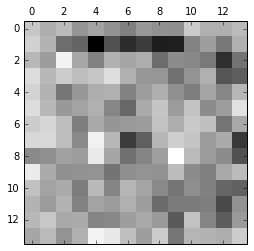

In [178]:
result = np.zeros((14, 14))
for i in range(64):
    result += _pool[0, :, :, i]
result /= 64
plt.matshow(result, cmap=plt.get_cmap('gray'))

In [152]:
out

array([[-20.6776619 , -19.97012901,  -3.16934848,   2.69226384,
        -12.21323967,  -8.20372105, -29.87957191,   7.06567049,
         -8.24401855,  -3.33923817]], dtype=float32)

In [140]:
_out = sess.run(tf.matmul(dense, weights['wd1']))

In [141]:
_out

array([[-20.71594238, -19.9842701 ,  -3.1866436 ,   2.7218008 ,
        -12.17050266,  -8.22147179, -29.84696388,   7.04544353,
         -8.14228725,  -3.30471683]], dtype=float32)

In [142]:
dense.shape

(1, 12544)

In [144]:
weights['wd1']

In [145]:
_w = sess.run(weights['wd1'])
_w.shape
_w[:, 6].reshape((1, 12544))

(12544, 10)

In [158]:
_out = sess.run(tf.matmul(_w[:, 7].reshape((1, 12544)), weights['wd1']))
_out

array([[   5.16257906,   24.18955994,   -3.72014236,    0.54560018,
           8.74892712,   -4.48493147,  -20.49009705,  236.7013855 ,
         -10.03568268,   -3.64904165]], dtype=float32)

In [153]:
train_Y[0, :]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [180]:

_out = sess.run(tf.matmul(_pool.reshape((1, 12544)), weights['wd1']))
_out

array([[ 0.02181052,  0.10219443, -0.01571661,  0.00230502,  0.03696188,
        -0.01894764, -0.08656516,  1.        , -0.04239807, -0.01541622]], dtype=float32)